# 📒 Scanner ID Pipeline (Combined Official + Wikipedia)
This notebook builds scanner fingerprints from flatfield images and trains classifiers on **Official + Wikipedia** documents together. Both an **SVM baseline** and a **TinyCNN** are included.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import os, glob, random
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple
from collections import Counter

from skimage import io, color
from skimage.util import img_as_float32
from skimage.restoration import denoise_wavelet
from skimage.feature import local_binary_pattern
from skimage.transform import resize

from numpy.fft import fft2, fftshift

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import joblib

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split


In [4]:

# ==== EDIT THESE PATHS FOR YOUR MACHINE ====
FLATROOT = r"D:\scanner_id_pipeline\data\flatfields"
OFFICIALROOT = r"D:\scanner_id_pipeline\data\Official"
WIKIROOT = r"D:\scanner_id_pipeline\data\Wikipedia"

def check_path(p):
    print(p, '=>', 'OK' if os.path.exists(p) else 'MISSING')

print('Checking your paths...')
check_path(FLATROOT)
check_path(OFFICIALROOT)
check_path(WIKIROOT)


Checking your paths...
D:\scanner_id_pipeline\data\flatfields => OK
D:\scanner_id_pipeline\data\Official => OK
D:\scanner_id_pipeline\data\Wikipedia => OK


In [5]:

def load_image_gray(path: str) -> np.ndarray:
    img = io.imread(path)
    if img.ndim == 3:
        if img.shape[-1] == 4:
            img = img[..., :3]
        img = color.rgb2gray(img)
    else:
        img = img.astype(np.float32) / (np.iinfo(img.dtype).max if np.issubdtype(img.dtype, np.integer) else 1.0)
    return img_as_float32(img)

def normalize_image(img: np.ndarray) -> np.ndarray:
    m, s = np.mean(img), np.std(img) + 1e-8
    return (img - m) / s

def residual_wavelet(img: np.ndarray) -> np.ndarray:
    den = denoise_wavelet(img, method='BayesShrink', mode='soft', rescale_sigma=True)
    res = img - den
    return res.astype(np.float32)


In [6]:

def list_images(root: str, exts=('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')) -> List[str]:
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, '**', f'*{ext}'), recursive=True))
    return sorted(files)

def group_by_scanner(root: str) -> Dict[str, List[str]]:
    paths = list_images(root)
    mapping = {}
    for p in paths:
        rel = os.path.relpath(p, root)
        scanner = rel.split(os.sep)[0]
        mapping.setdefault(scanner, []).append(p)
    return mapping

def extract_patches(img: np.ndarray, patch: int = 128, stride: int = 128, min_margin: int = 16) -> np.ndarray:
    H, W = img.shape
    patches = []
    for y in range(min_margin, H - patch - min_margin + 1, stride):
        for x in range(min_margin, W - patch - min_margin + 1, stride):
            patches.append(img[y:y+patch, x:x+patch])
    return np.stack(patches, axis=0) if patches else np.empty((0, patch, patch), dtype=img.dtype)


In [7]:

def build_document_residual_dataset(
    docroot: str,
    patch: int = 128,
    stride: int = 256,
    min_margin: int = 16,
    max_patches_per_doc: int = 100
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    if not os.path.exists(docroot):
        raise FileNotFoundError(f'Document root not found: {docroot}')
    by_scanner = group_by_scanner(docroot)
    if not by_scanner:
        raise FileNotFoundError(f'No images found under: {docroot}')
    X_list, y_list = [], []
    label_names = sorted(by_scanner.keys())
    label_to_idx = {lab: i for i, lab in enumerate(label_names)}
    for lab in label_names:
        for p in by_scanner[lab]:
            img = load_image_gray(p)
            img = normalize_image(img)
            res = residual_wavelet(img)
            patches = extract_patches(res, patch=patch, stride=stride, min_margin=min_margin)
            if len(patches) > max_patches_per_doc:
                patches = patches[np.random.choice(len(patches), max_patches_per_doc, replace=False)]
            for ph in patches:
                X_list.append(ph)
                y_list.append(label_to_idx[lab])
    if not X_list:
        raise RuntimeError('No patches were extracted. Check your images/paths.')
    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y, label_names


In [9]:

def lbp_hist(patch: np.ndarray, P: int = 16, R: int = 2) -> np.ndarray:
    lbp = local_binary_pattern(patch, P, R, method='uniform')
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

def fft_radial_stats(patch: np.ndarray, n_bins: int = 16) -> np.ndarray:
    F = fftshift(fft2(patch))
    P = np.abs(F) ** 2
    H, W = P.shape
    cy, cx = H//2, W//2
    y, x = np.indices(P.shape)
    r = np.sqrt((y - cy)**2 + (x - cx)**2)
    r_norm = r / (r.max() + 1e-8)
    bins = np.linspace(0, 1.0, n_bins+1)
    feats = []
    for i in range(n_bins):
        mask = (r_norm >= bins[i]) & (r_norm < bins[i+1])
        feats.append(P[mask].mean() if np.any(mask) else 0.0)
    feats = np.log1p(np.array(feats, dtype=np.float32))
    return (feats - feats.mean()) / (feats.std() + 1e-8)

def features_from_patch(patch: np.ndarray) -> np.ndarray:
    return np.concatenate([lbp_hist(patch), fft_radial_stats(patch)], axis=0)

def features_from_residual_patches(patches: np.ndarray, batch_size: int = 5000) -> np.ndarray:
    feats = []
    for i in range(0, len(patches), batch_size):
        batch = patches[i:i+batch_size]
        feats.extend([features_from_patch(p) for p in batch])
        print(f"Processed {min(i+batch_size, len(patches))} / {len(patches)} patches...")
    return np.array(feats, dtype=np.float32)


In [10]:

def make_svm_pipeline(C: float = 10.0, gamma: str | float = 'scale') -> Pipeline:
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(C=C, kernel='rbf', gamma=gamma, probability=True, class_weight='balanced'))
    ])

def train_and_eval(X, y, labels, test_size=0.25):
    if len(np.unique(y)) < 2:
        raise ValueError('Need at least 2 classes to train a classifier.')
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    model = make_svm_pipeline()
    model.fit(Xtr, ytr)
    # training acc
    yhat_tr = model.predict(Xtr)
    train_acc = accuracy_score(ytr, yhat_tr)
    # test acc
    yhat_te = model.predict(Xte)
    test_acc = accuracy_score(yte, yhat_te)
    print("Training Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print(classification_report(yte, yhat_te, target_names=labels))
    cm = confusion_matrix(yte, yhat_te)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(xticks_rotation=45)
    plt.show()
    return model


In [12]:

class PatchDataset(Dataset):
    def __init__(self, patches: np.ndarray, labels: np.ndarray):
        self.X = patches.astype(np.float32)
        self.y = labels.astype(np.int64)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][None, ...]), torch.tensor(self.y[idx])

import torchvision.models as models
import torch.nn.functional as F

class ResNetScanner(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        # Load pretrained ResNet18
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify first conv layer to accept 1-channel input (grayscale patches)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final FC layer with classifier for scanners
        in_feats = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_feats, n_classes)

    def forward(self, x):
        return self.resnet(x)


def train_resnet(patches, labels, epochs=20, batch=64, lr=1e-4):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ds = PatchDataset(patches, labels)
    if len(ds) < 10:
        raise ValueError("Not enough patches to train CNN.")

    n_val = max(1, int(0.2 * len(ds)))
    n_train = len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    train_dl = DataLoader(train_ds, batch_size=batch, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch)

    model = ResNetScanner(int(labels.max()+1)).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    for ep in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        # Validation per epoch
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb).argmax(1)
                correct += (pred == yb).sum().item()
                total += len(yb)
        val_acc = correct / max(1, total)
        print(f"Epoch {ep+1}/{epochs}, Val Acc: {val_acc:.3f}")

    # Final Training Accuracy
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += len(yb)
    train_acc = correct / max(1, total)

    # Final Test Accuracy
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += len(yb)
    test_acc = correct / max(1, total)

    print(f"\nFinal Training Accuracy: {train_acc:.3f}")
    print(f"Final Test Accuracy: {test_acc:.3f}")

    return model, train_acc, test_acc


In [13]:

X_off, y_off, labels_off = build_document_residual_dataset(OFFICIALROOT, stride=256, max_patches_per_doc=100)
X_wiki, y_wiki, labels_wiki = build_document_residual_dataset(WIKIROOT, stride=256, max_patches_per_doc=100)

union_labels = sorted(list(set(labels_off) | set(labels_wiki)))
map_union = {lab: i for i, lab in enumerate(union_labels)}
y_off_mapped = np.array([map_union[labels_off[idx]] for idx in y_off])
y_wiki_mapped = np.array([map_union[labels_wiki[idx]] for idx in y_wiki])

X_comb = np.concatenate([X_off, X_wiki], axis=0)
y_comb = np.concatenate([y_off_mapped, y_wiki_mapped], axis=0)
perm = np.random.RandomState(42).permutation(len(y_comb))
X_comb, y_comb = X_comb[perm], y_comb[perm]

print("Combined dataset:", X_comb.shape, "classes:", union_labels)


Combined dataset: (28305, 128, 128) classes: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


d:\scanner_id_pipeline\scanner_env\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processed 2000 / 28305 patches...
Processed 4000 / 28305 patches...
Processed 6000 / 28305 patches...
Processed 8000 / 28305 patches...
Processed 10000 / 28305 patches...
Processed 12000 / 28305 patches...
Processed 14000 / 28305 patches...
Processed 16000 / 28305 patches...
Processed 18000 / 28305 patches...
Processed 20000 / 28305 patches...
Processed 22000 / 28305 patches...
Processed 24000 / 28305 patches...
Processed 26000 / 28305 patches...
Processed 28000 / 28305 patches...
Processed 28305 / 28305 patches...
Training Accuracy: 0.7644620312794422
Test Accuracy: 0.7049597286986011
              precision    recall  f1-score   support

  Canon120-1       0.36      0.51      0.42       282
  Canon120-2       0.55      0.56      0.56       318
    Canon220       0.76      0.77      0.76       656
 Canon9000-1       0.60      0.76      0.67       390
 Canon9000-2       0.64      0.56      0.60       460
 EpsonV370-1       0.56      0.55      0.55       925
 EpsonV370-2       0.69     

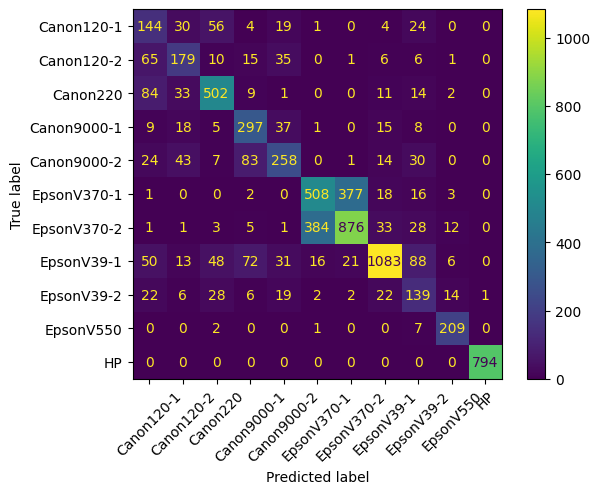

Saved SVM to artifacts/baseline_svm_combined.joblib


In [16]:

feats_comb = features_from_residual_patches(X_comb, batch_size=2000)
svm_model = train_and_eval(feats_comb, y_comb, union_labels)
os.makedirs("artifacts", exist_ok=True)
joblib.dump({'model': svm_model, 'labels': union_labels}, "artifacts/baseline_svm_combined.joblib")
print("Saved SVM to artifacts/baseline_svm_combined.joblib")


In [15]:
cnn_model, train_acc, test_acc = train_resnet(X_comb, y_comb, epochs=20, batch=64, lr=1e-4)

torch.save({'state_dict': cnn_model.state_dict(), 'labels': union_labels},
           "artifacts/cnn_resnet18_combined.pt")

print("Saved CNN to artifacts/cnn_resnet18_combined.pt")


Epoch 1/20, Val Acc: 0.496
Epoch 2/20, Val Acc: 0.513
Epoch 3/20, Val Acc: 0.405
Epoch 4/20, Val Acc: 0.408
Epoch 5/20, Val Acc: 0.429
Epoch 6/20, Val Acc: 0.604
Epoch 7/20, Val Acc: 0.468
Epoch 8/20, Val Acc: 0.461
Epoch 9/20, Val Acc: 0.414
Epoch 10/20, Val Acc: 0.397
Epoch 11/20, Val Acc: 0.537
Epoch 12/20, Val Acc: 0.462
Epoch 13/20, Val Acc: 0.523
Epoch 14/20, Val Acc: 0.452
Epoch 15/20, Val Acc: 0.461
Epoch 16/20, Val Acc: 0.425
Epoch 17/20, Val Acc: 0.551
Epoch 18/20, Val Acc: 0.464
Epoch 19/20, Val Acc: 0.508
Epoch 20/20, Val Acc: 0.521

Final Training Accuracy: 0.557
Final Test Accuracy: 0.521
Saved CNN to artifacts/cnn_resnet18_combined.pt
